In [68]:
import numpy as np
import pandas as pd
import math
from scipy.stats import poisson
import time
import matplotlib.pyplot as plt
import plotly.express as px


## Functions

In [2]:
I = 48  # Number of intervals
d = 5  # length of interval
x = np.random.choice(5, I)
N = sum(x)
precision = 0.9999
beta = 9  # Average service time for a patient
no_show = 0 # Fraction of scheduled patients not showing up
eind = 0
alpha_I = 0.2
alpha_T = 0.4  # patient doctor centric slider
alpha_W = 0.4

print(N)

97


In [3]:
def calcExponentialLimit(mu):
    return int(max(mu+4*mu**0.5, 100))

In [4]:
def binomCoeff(k, i):
  return math.factorial(k) / (math.factorial(k - i) * math.factorial(i))


def binomPMF(k, i, m, add_v, no_show):
  return binomCoeff(k, m) * add_v[m][i] * (1 - no_show)**m * no_show**(k-m)

In [5]:
# Distribution to calculate service time of patients
#	p[i]= probability of serving the patient in i mins given that
#	the average service time is beta.
def calculate_p(beta, size, precision=0.9999):  # Poisson distribution
    k = 0
    p = []

    while sum(p) < precision:  # fill accurate values up to precision limit
        p.append(poisson.pmf(k, beta))
        k += 1

    while len(p) < size:  # fill the rest of the values with 0
        p.append(0)
    return p, k

##########
## TEST ##
##########

probS = calcExponentialLimit(beta*N)+1
print(probS)
calculate_p(beta, probS, precision)


992


([0.00012340980408667956,
  0.0011106882367801166,
  0.004998097065510523,
  0.014994291196531574,
  0.033737155192196056,
  0.06072687934595293,
  0.09109031901892926,
  0.1171161244529091,
  0.13175564000952278,
  0.13175564000952278,
  0.11858007600857066,
  0.09702006218883041,
  0.0727650466416229,
  0.050375801521123684,
  0.03238444383500792,
  0.01943066630100472,
  0.010929749794315179,
  0.005786338126402172,
  0.0028931690632010803,
  0.0013704485036215655,
  0.0006167018266297063,
  0.0002643007828413016,
  0.00010812304752598687,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [6]:
def calculate_v(p, beta, precision, precision_limit, N, d, no_show=0):
  count = precision_limit
  limit = calcExponentialLimit(beta*N) + 1
  v = np.zeros((N+1, limit+d))
  add_v = np.zeros((N+1, limit+d))

  add_v[0][0] = 1
  for k in range(1, N+1):
    limit = calcExponentialLimit(beta*k)
    i = 0
    sum_v = 0
    while sum_v < precision and i <= limit:
      z = 0
      while z <= count:
        add_v[k][i] += p[z] * add_v[k-1][i-z]
        z += 1
      sum_v += add_v[k][i]
      i += 1

  for k in range(N+1):
    i = 0
    sum_v = 0
    while sum_v < precision and i <= limit:
      for m in range(k+1):
        v[k][i] += binomPMF(k, i, m, add_v, no_show)
      sum_v += v[k][i]
      i += 1

  return v, limit

##########
## TEST ##
##########

p, precision_limit = calculate_p(beta, probS, precision)
calculate_v(p, beta, precision, precision_limit, N, d, no_show)


(array([[1.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.23409804e-04, 1.11068824e-03, 4.99809707e-03, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [1.52299797e-08, 2.74139635e-07, 2.46725672e-06, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [5.01222975e-08, 2.42155501e-08, 1.10641659e-08, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]),
 991)

In [7]:
def calculateProbabilities(x, precision, limit, v, I, d):
  p_plus = np.zeros((I+1, limit+d+1))
  p_min = np.zeros((I+1, limit+d+1))

  # Constraint 1
  p_min[0][0] = 1

  # Constraint 2
  sum_p = 0
  i = 0
  while sum_p < precision and i <= limit:
    p_plus[0][i] = v[x[0]][i]
    sum_p += p_plus[0][i]
    i += 1

  for t in range(1, I+1):  # calculate p_min and p_plus iteratively
    # Constraint 3
    for k in range(d+1):
      # probability of amount of work = 0 just before the start of t equals the cummulative probablity of amount of work less or equal to duration of the interval just at the start of the previous interval, t-1
      p_min[t][0] += p_plus[t-1][k]
    # Constraint 4
    for i in range(1, limit+1):

      # probability of amount of work = i just before the start of interval t equals the probablity of amount of work exceeding the duration of the interval by i just at the start of the previous interval, t-1
      p_min[t][i] = p_plus[t-1][i+d]

    # Constraint 5
    if t != I:  # I or I+1
      for i in range(limit+1):
        for j in range(i+1):
          p_plus[t][i] += p_min[t][j] * v[x[t]][i-j]

  return p_min, limit

##########
## TEST ##
##########

v, limit = calculate_v(p, beta, precision, precision_limit, N, d, no_show)
p_min, limit = calculateProbabilities(x, precision, limit, v, I, d)


In [8]:
def calcTardiness(p_min, limit, I):
  tardiness = 0
  # print(p_min[I])
  for k in range(limit):
    tardiness += k * p_min[I][k]  # I+1
  return tardiness


def calcIdletime(I, d, tardiness, N, no_show, beta):
  return (I * d) + tardiness - (N * (1 - no_show) * beta)  # I-1?


def calcWaitingtime(p_min, x, p, limit, I, N):
  w = np.zeros((I+1, N+1, limit+1))
  waitingtime = 0

  for t in range(0, I):
    if x[t] > 0:
      for k in range(limit):
        w[t][0][k] = p_min[t][k]
    if x[t] > 1:
      for i in range(1, x[t]+1):
        for k in range(limit+1):
          for j in range(k+1):
            w[t][i][k] += w[t][i-1][j] * p[k-j]

  for t in range(0, I):
    for i in range(0, x[t]):
      for k in range(limit+1):
        waitingtime += w[t][i][k] * k

  waitingtime /= N
  return waitingtime

##########
## TEST ##
##########

calcWaitingtime(p_min, x, p, limit, I, N)


316.0065382055963

In [9]:
def calcFracExcess(p_min, I):
  fracExcess = 0
  t = I+1
  for j in range(1, len(p_min[t])):
    fracExcess += p_min[t][j]
  fracExcess *= 100
  return fracExcess


##########
## TEST ##
##########

# calcFracExcess(p_min, I)


<div>
<img src="https://github.com/witusj/obp/blob/master/images/fitness2.png?raw=true" width="450">
<img src="https://github.com/witusj/obp/blob/master/images/fitness.png?raw=true" width="450">
</div>

In [10]:
def calcFitness(x, beta, precision, limit, v, N, no_show, I, d, eind, alpha_W, alpha_I, alpha_T):
  tic = time.perf_counter()
  p_min, limit = calculateProbabilities(x, precision, limit, v, I, d)
  toc = time.perf_counter()
  probT = toc-tic

  # Tardiness calcs
  tic = time.perf_counter()
  tardiness = calcTardiness(p_min, limit, I)
  toc = time.perf_counter()
  tardT = toc-tic

  # Idle time calcs new array of given shape and type, filled with zeros.
  tic = time.perf_counter()
  idletime = calcIdletime(I, d, tardiness, N, no_show, beta)
  toc = time.perf_counter()
  idletimeT = toc-tic

  # Waiting time calcs
  tic = time.perf_counter()
  waitingtime = calcWaitingtime(p_min, x, p, limit, I, N)
  toc = time.perf_counter()
  waitingtimeT = toc-tic

  objVal = alpha_W*waitingtime + alpha_I*idletime + alpha_T*tardiness

  print(f"Schedule: {x},\nN: {sum(x)},\nObjective value: {objVal},\nProb calculation time: {probT:.6f} sec,\nWaiting time (timer): {waitingtime} ({waitingtimeT:.6f} sec),\nIdle time (timer): {idletime} ({idletimeT:.6f} sec),\nTardiness (timer): {tardiness} ({tardT:.6f} sec)\n")

  # Collect into a dictionary
  results = {'p_min': p_min, 'waitingTime': waitingtime,
            'idleTime': idletime, 'tardiness': tardiness, 'objVal': objVal}

  if eind == 1:
    fracExcess = calcFracExcess(p_min, I)
    results['fracExcess'] = fracExcess

  return results

##########
## TEST ##
##########


p, precision_limit = calculate_p(beta, probS, precision)
v, limit = calculate_v(p, beta, precision, precision_limit, N, d, no_show)



results = calcFitness(x, beta, precision, limit, v, N, no_show,
                  I, d, eind, alpha_W, alpha_I, alpha_T)
results


Schedule: [2 3 4 0 0 2 4 0 2 4 2 1 1 3 4 1 2 1 4 0 3 4 1 3 1 3 4 1 3 0 4 1 0 2 4 0 1
 4 1 4 0 2 0 3 3 3 0 2],
N: 97,
Objective value: 377.0923012083026,
Prob calculation time: 19.858464 sec,
Waiting time (timer): 316.0065382055963 (45.061538 sec),
Idle time (timer): -4.183856789893184 (0.000003 sec),
Tardiness (timer): 628.8161432101068 (0.000444 sec)



{'p_min': array([[1.00000000e+000, 0.00000000e+000, 0.00000000e+000, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [3.23993451e-004, 7.19452059e-004, 1.85001958e-003, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [1.39754723e-010, 5.98532450e-010, 2.64341098e-009, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        ...,
        [9.43406374e-145, 5.36532193e-144, 3.15962562e-143, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [5.25531768e-141, 1.91765929e-140, 8.47117073e-140, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000],
        [6.33044459e-144, 2.51317596e-143, 1.13312964e-142, ...,
         0.00000000e+000, 0.00000000e+000, 0.00000000e+000]]),
 'waitingTime': 316.0065382055963,
 'idleTime': -4.183856789893184,
 'tardiness': 628.8161432101068,
 'objVal': 377.0923012083026}

In [11]:
def createDist(arr, reverse=False):
    minX, maxX = arr.min(), arr.max()
    minY, maxY = 0, 1
    if(reverse):
        minY, maxY = maxY, minY
    # Scale to values between 0, 1 and make total sum equal to 1
    arrScaled = np.interp(arr, (minX, maxX), (minY, maxY))
    arrNorm = [x / arrScaled.sum() for x in arrScaled]
    return(arrNorm)
    

##########
## TEST ##
##########

arr = np.random.choice(10, 5)
dist1 = createDist(arr)
dist2 = createDist(arr, reverse=True)
arr, dist1, sum(dist1), dist2, sum(dist2)


(array([4, 6, 8, 4, 6]),
 [0.0, 0.25, 0.5, 0.0, 0.25],
 1.0,
 [0.3333333333333333,
  0.16666666666666666,
  0.0,
  0.3333333333333333,
  0.16666666666666666],
 0.9999999999999999)

<div>
<img src="https://github.com/witusj/obp/blob/master/images/crossover.png?raw=true" width="450">
<img src="https://github.com/witusj/obp/blob/master/images/crossover2.png?raw=true" width="450">
</div>

In [12]:
## OLD
def crossover(parent1, parent2, nSwaps):
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    I = len(child1)
    
    # Calculate distribution for choosing intervals that will swap patients
    # The distribution is the normalized schedule. Intervals with zero patients will never be selected.
    # norm1 = sum(child1)
    # p1 = child1 / norm1
    p1 = createDist(child1)
    
    # The number of swaps should not exceed the maximum number of patients in any interval. Otherwise it might happen that the number of patients that are transfered exceeds availability, resulting in a negative amount.
    max1 = int(max(child1))
    max2 = int(max(child2))
    nSwaps = min(nSwaps, max1, max2)
    
    # Swap patients parent1 to parent 2
    i = np.random.choice(I, nSwaps, p=p1)
    for i in i:
        child1[i] += -1
        child2[i] += 1
    
    # Swap patients parent2 to parent 1
    # norm2 = sum(child2)
    # p2 = child2 / norm2
    p2 = createDist(child2)
    
    j = np.random.choice(I, nSwaps, p=p2)
    for j in j:
        child1[j] += 1
        child2[j] += -1
    return(child1, child2)

##########
## TEST ##
##########


parent1 = np.random.choice(5, I)
parent2 = np.random.choice(5, I)

print(parent1, parent2)
nSwaps = 3
children = crossover(parent1, parent2, nSwaps)
children


[2 2 0 0 2 2 3 2 0 4 1 4 4 1 4 1 3 3 0 2 0 2 0 4 1 1 3 2 4 3 3 4 1 2 3 0 0
 0 0 0 3 4 2 1 4 1 0 0] [0 2 3 1 4 0 3 2 3 4 2 1 3 3 2 4 3 0 3 3 4 4 1 4 3 1 0 2 1 2 1 0 3 3 2 4 4
 1 2 2 3 2 3 1 0 4 3 4]


(array([2, 2, 1, 0, 2, 2, 3, 2, 0, 3, 1, 3, 4, 1, 4, 2, 3, 3, 0, 2, 0, 2,
        0, 4, 1, 1, 3, 2, 5, 3, 3, 4, 1, 2, 3, 0, 0, 0, 0, 0, 3, 4, 2, 1,
        3, 1, 0, 0]),
 array([0, 2, 2, 1, 4, 0, 3, 2, 3, 5, 2, 2, 3, 3, 2, 3, 3, 0, 3, 3, 4, 4,
        1, 4, 3, 1, 0, 2, 0, 2, 1, 0, 3, 3, 2, 4, 4, 1, 2, 2, 3, 2, 3, 1,
        1, 4, 3, 4]))

In [13]:
def crossover(parent1, parent2, nSwaps):
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    I = len(child1)
    
    # Calculate distribution for choosing intervals that will swap patients
    # The distribution is the normalized schedule. Intervals with zero patients will never be selected.
    p1 = createDist(child1)
    
    # Swap patients parent1 to parent 2
    n1 = nSwaps
    while(n1 > 0):
        i = np.random.choice(I, 1, p=p1)
        child1[i] += -1
        child2[i] += 1
        if(child1[i] == 0):
            p1 = createDist(child1) # If the number of patients in interval i reaches zero, this interval should not be selected again.
        n1 -= 1
    
    # Swap patients parent2 to parent 1
    p2 = createDist(child2)
    
    n2 = nSwaps
    while(n2 > 0):
        i = np.random.choice(I, 1, p=p2)
        child2[i] += -1
        child1[i] += 1
        if(child2[i] == 0):
            p2 = createDist(child2)
        n2 -= 1
        
    return(child1, child2)

##########
## TEST ##
##########

testI = 10
parent1 = np.random.choice(5, testI)
parent2 = np.random.choice(5, testI)

print(parent1, parent2)
nSwaps = 3
children = crossover(parent1, parent2, nSwaps)
children


[1 3 2 1 2 2 1 4 0 0] [2 0 3 3 4 0 1 2 2 2]


(array([1, 3, 3, 0, 2, 2, 1, 3, 0, 1]), array([2, 0, 2, 4, 4, 0, 1, 3, 2, 1]))


<div>
    <img src="https://github.com/witusj/obp/blob/master/images/mutation.png?raw=true" width="450">
    <img src="https://github.com/witusj/obp/blob/master/images/mutation1.png?raw=true" width="450">
</div>

In [14]:
def mutate(child, rate):
    if np.random.rand() < rate:
        x = len(child)
        i, j = np.random.choice(x, 2, replace=False).astype(int)
        a, b = child[i], child[j]
        child[i], child[j] = b, a
    return(child)

##########
## TEST ##
##########

child = children[0].copy()
print(child)
child = mutate(child, 1)
print(child)


[1 3 3 0 2 2 1 3 0 1]
[1 3 3 0 2 2 1 0 3 1]


## Classes

#### Suggesties: [get / set methods](https://www.geeksforgeeks.org/getter-and-setter-in-python/) voor parameters / met tests / nuttig voor optimaliseren hyper parameters, bv mbv bayesian stats

Create a data object to store and generate initial data.

In [15]:
class Data:
    def __init__(self, I=10, N=12, d=5, popSize=5, beta=9, precision=0.9999, no_show=0, eind=0, alpha_I=0.2, alpha_T=0.3, alpha_W=0.5, nSwaps=4, mutationRate=0.1):
        self.I = I
        self.N = N
        self.d = d
        self.popSize = popSize
        self.beta = beta
        self.precision = precision
        self.no_show = no_show
        self.probSize = calcExponentialLimit(self.beta*self.N)+1
        self.p, self.precision_limit = self.__calculate_p()
        self.v, self.limit = self.__calculate_v()
        self.eind = eind
        self.alpha_I, self.alpha_T, self.alpha_W = alpha_I, alpha_T, alpha_W
        self.nSwaps, self.mutationRate = nSwaps, mutationRate
    
    def get_initial_data(self): return np.array((self.I, self.N, self.d, self.beta, self.popSize, self.eind, self.alpha_I, self.alpha_T, self.alpha_W, self.nSwaps, self.mutationRate),
                                                dtype={'names': ('I', 'N', 'd', 'beta', 'popSize', 'eind', 'alpha_I', 'alpha_T', 'alpha_W', 'nSwaps', 'mutationRate'),
                                                'formats': ('i4', 'i4', 'i4', 'i4', 'i4', 'i4', 'f8', 'f8', 'f8', 'i4', 'f8')})

    def get_prob_data(self): return np.array((self.precision, self.no_show, self.probSize, self.precision_limit, self.limit),
                                                dtype={'names': ('precision', 'no_show', 'probSize', 'precision_limit', 'limit'),
                                                'formats': ('f8', 'f8', 'i4', 'f8', 'i4')})

    def calculate_p(self):  return calculate_p(self.beta, self.probSize, self.precision)
    __calculate_p = calculate_p
    
    def calculate_v(self): return calculate_v(self.p, self.beta, self.precision, self.precision_limit, self.N, self.d, self.no_show)
    __calculate_v = calculate_v
    

##########
## TEST ##
##########

newDataObject = Data(I, N)
initData = newDataObject.get_initial_data()
initData[['N', 'popSize']]


array((97, 5),
      dtype={'names': ['N', 'popSize'], 'formats': ['<i4', '<i4'], 'offsets': [4, 16], 'itemsize': 60})

<img src="https://github.com/witusj/obp/blob/master/images/population.png?raw=true" width="600">

Create a random individual. An individual is in this case one schedule.

In [16]:
class Schedule:
    def __init__(self, dataObject):
        self.I = dataObject.get_initial_data()['I']  # Number of intervals
        self.N = dataObject.get_initial_data()['N']  # Number of patients
        self.x = np.zeros(self.I).astype(int)# Empty schedule

    def create_random_schedule(self):
        for i in range(self.N):
            i = np.random.choice(self.I, 1)  # Interval ID
            self.x[i] = self.x[i] + 1
    def get_schedule(self): return(self.x)
    def print_schedule(self): print(self.x)


##########
## TEST ##
##########

dataObject = Data(I=I, N=N, d=d)
scheduleObject = Schedule(dataObject)
scheduleObject.print_schedule()
scheduleObject.create_random_schedule()
schedule = scheduleObject.get_schedule()
schedule

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]


array([3, 2, 5, 1, 3, 3, 3, 3, 2, 1, 3, 4, 5, 3, 1, 2, 1, 1, 2, 2, 0, 0,
       1, 2, 1, 2, 1, 2, 2, 3, 2, 3, 2, 1, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1,
       2, 4, 3, 2])

Create population of individuals

In [37]:
class Population:
    global bestRank
    bestRank = []
    def __init__(self, dataObject, individuals=None):
        self.dataObject = dataObject
        self.params = self.dataObject.get_initial_data()
        self.prob_params = self.dataObject.get_prob_data()
        self.p, self.v = self.dataObject.p, self.dataObject.v
        self.individuals = individuals
        if self.individuals == None: self.__create_new_individuals() 
        self.fitnessScores = []

    def create_new_individuals(self):
        self.individuals = []
        for i in range(self.params['popSize']):
            x = Schedule(self.dataObject)
            x.create_random_schedule()
            x = x.get_schedule()
            self.individuals.append(x)
            
    __create_new_individuals = create_new_individuals
    
    def get_individuals(self): return(self.individuals)
    
    def calc_fitness_scores(self):
            beta, N, I, d, eind, alpha_W, alpha_I, alpha_T = self.params[['beta', 'N', 'I', 'd', 'eind', 'alpha_W', 'alpha_I', 'alpha_T']].tolist()
            precision, limit, no_show = self.prob_params[['precision', 'limit', 'no_show']].tolist()
            self.fitnessScores = np.array([calcFitness(x, beta=beta, precision=precision, limit=limit, v=self.v, N=N, no_show=no_show, I=I, d=d, eind=eind, alpha_W=alpha_W, alpha_I=alpha_I, alpha_T=alpha_T)['objVal'] for x in self.individuals])
            
    def apply_crossover(self):
        newIndividuals = []
        nSwaps = self.params['nSwaps']*1 ## Times 1 because otherwise refers to memorypoint
        mutationRate = self.params['mutationRate']
        self.population_dist = createDist(self.fitnessScores, reverse=True)
        
        for i in range(self.params['popSize']):
            print(f'Crossover {i}')
            r1, r2 = np.random.choice(self.params['popSize'], 2, replace=False, p=self.population_dist)
            parent1, parent2 = self.individuals[r1], self.individuals[r2]
            child1, child2 = crossover(parent1, parent2, nSwaps)
            newIndividuals.append(mutate(child1, mutationRate))
            newIndividuals.append(mutate(child2, mutationRate))
            
        beta, N, I, d, eind, alpha_W, alpha_I, alpha_T = self.params[[
            'beta', 'N', 'I', 'd', 'eind', 'alpha_W', 'alpha_I', 'alpha_T']].tolist()
        precision, limit, no_show = self.prob_params[[
            'precision', 'limit', 'no_show']].tolist()
        self.fitnessScores = np.array([calcFitness(x, beta=beta, precision=precision, limit=limit, v=self.v, N=N, no_show=no_show,
                                            I=I, d=d, eind=eind, alpha_W=alpha_W, alpha_I=alpha_I, alpha_T=alpha_T)['objVal'] for x in newIndividuals])
        tempList = list(range(self.params['popSize']*2))
        zipped = list(zip(*sorted(zip(self.fitnessScores, tempList))))
        self.fitnessScores = np.array(list(zipped[0][:self.params['popSize']]))
        tempList = zipped[1][:self.params['popSize']]
        self.individuals = list(map(newIndividuals.__getitem__, tempList))
        bestRank.append([self.fitnessScores[0], self.individuals[0]])
        print(self.fitnessScores, '\n', self.individuals)


## Tests

In [56]:
##########
## TEST ##
##########

bestRank = []
dataObject = Data()
populationObject1 = Population(dataObject)
populationObject1.fitnessScores
populationObject1.calc_fitness_scores()
print(populationObject1.fitnessScores)


Schedule: [2 0 1 0 1 2 0 0 5 1],
N: 12,
Objective value: 28.757279405129218,
Prob calculation time: 0.096947 sec,
Waiting time (timer): 22.556461139762217 (0.094977 sec),
Idle time (timer): 0.15809767049623247 (0.000002 sec),
Tardiness (timer): 58.158097670496225 (0.000064 sec)

Schedule: [0 0 1 1 2 1 2 1 2 2],
N: 12,
Objective value: 37.40730461871096,
Prob calculation time: 0.081941 sec,
Waiting time (timer): 29.983673621800406 (0.081578 sec),
Idle time (timer): 10.030935615621516 (0.000002 sec),
Tardiness (timer): 68.03093561562152 (0.000057 sec)

Schedule: [0 2 1 5 0 0 1 0 1 2],
N: 12,
Objective value: 36.48321345565847,
Prob calculation time: 0.082948 sec,
Waiting time (timer): 33.22842575653842 (0.106637 sec),
Idle time (timer): 4.938001154778533 (0.000002 sec),
Tardiness (timer): 62.938001154778526 (0.000057 sec)

Schedule: [2 0 1 1 3 0 2 1 1 1],
N: 12,
Objective value: 31.097923796224226,
Prob calculation time: 0.094642 sec,
Waiting time (timer): 27.42281080007287 (0.083905 sec

In [57]:
individuals2 = populationObject1.individuals.copy()
populationObject2 = Population(dataObject, individuals=individuals2)
print(populationObject1.individuals, '\n', populationObject2.individuals)

[array([2, 0, 1, 0, 1, 2, 0, 0, 5, 1]), array([0, 0, 1, 1, 2, 1, 2, 1, 2, 2]), array([0, 2, 1, 5, 0, 0, 1, 0, 1, 2]), array([2, 0, 1, 1, 3, 0, 2, 1, 1, 1]), array([3, 2, 0, 2, 0, 2, 0, 2, 1, 0])] 
 [array([2, 0, 1, 0, 1, 2, 0, 0, 5, 1]), array([0, 0, 1, 1, 2, 1, 2, 1, 2, 2]), array([0, 2, 1, 5, 0, 0, 1, 0, 1, 2]), array([2, 0, 1, 1, 3, 0, 2, 1, 1, 1]), array([3, 2, 0, 2, 0, 2, 0, 2, 1, 0])]


In [58]:
populationObject2.calc_fitness_scores()
populationObject2.apply_crossover()
populationObject2.individuals


Schedule: [2 0 1 0 1 2 0 0 5 1],
N: 12,
Objective value: 28.757279405129218,
Prob calculation time: 0.112439 sec,
Waiting time (timer): 22.556461139762217 (0.110045 sec),
Idle time (timer): 0.15809767049623247 (0.000003 sec),
Tardiness (timer): 58.158097670496225 (0.000085 sec)

Schedule: [0 0 1 1 2 1 2 1 2 2],
N: 12,
Objective value: 37.40730461871096,
Prob calculation time: 0.092003 sec,
Waiting time (timer): 29.983673621800406 (0.085729 sec),
Idle time (timer): 10.030935615621516 (0.000002 sec),
Tardiness (timer): 68.03093561562152 (0.000055 sec)

Schedule: [0 2 1 5 0 0 1 0 1 2],
N: 12,
Objective value: 36.48321345565847,
Prob calculation time: 0.088070 sec,
Waiting time (timer): 33.22842575653842 (0.102922 sec),
Idle time (timer): 4.938001154778533 (0.000002 sec),
Tardiness (timer): 62.938001154778526 (0.000058 sec)

Schedule: [2 0 1 1 3 0 2 1 1 1],
N: 12,
Objective value: 31.097923796224226,
Prob calculation time: 0.081496 sec,
Waiting time (timer): 27.42281080007287 (0.076926 sec

[array([2, 0, 0, 1, 3, 0, 1, 1, 3, 1]),
 array([1, 0, 3, 0, 1, 2, 0, 0, 4, 1]),
 array([1, 0, 1, 1, 3, 0, 2, 1, 2, 1]),
 array([1, 1, 1, 3, 1, 0, 2, 1, 1, 1]),
 array([2, 2, 0, 0, 1, 2, 2, 2, 1, 0])]

In [59]:
# Initial population
bestRank = []
dataObject = Data()
populationZero = Population(dataObject)
populationZero.calc_fitness_scores()
individuals = populationZero.individuals.copy()
generations = 3

# Genetic algorithm loop
for i in range(generations):
    print(f'Generation: {i}')
    populationObject = Population(dataObject, individuals=individuals)
    populationObject.calc_fitness_scores()
    populationObject.apply_crossover()
    individuals = populationObject.individuals


Schedule: [1 1 2 0 1 0 2 2 2 1],
N: 12,
Objective value: 29.71454993146402,
Prob calculation time: 0.107699 sec,
Waiting time (timer): 24.577315484687187 (0.090251 sec),
Idle time (timer): 0.05178437824085336 (0.000002 sec),
Tardiness (timer): 58.05178437824085 (0.000065 sec)

Schedule: [3 0 1 3 1 1 1 1 1 0],
N: 12,
Objective value: 33.56860197091742,
Prob calculation time: 0.084553 sec,
Waiting time (timer): 32.39525718589919 (0.072408 sec),
Idle time (timer): -0.05805324406435375 (0.000002 sec),
Tardiness (timer): 57.941946755935646 (0.000057 sec)

Schedule: [1 2 1 1 2 2 0 0 2 1],
N: 12,
Objective value: 31.77461241960711,
Prob calculation time: 0.095824 sec,
Waiting time (timer): 28.72364021603046 (0.116591 sec),
Idle time (timer): 0.02558462318376087 (0.000003 sec),
Tardiness (timer): 58.025584623183754 (0.000071 sec)

Schedule: [1 1 2 0 3 2 1 0 1 1],
N: 12,
Objective value: 31.787630533373893,
Prob calculation time: 0.093677 sec,
Waiting time (timer): 28.735195686131956 (0.084758 

In [60]:

bestRankDF = pd.DataFrame(bestRank, columns=['Score', 'Schedule'])
bestRank
bestRankDF

,Score,Schedule
0,29.740718,"[1, 1, 2, 0, 0, 1, 3, 1, 2, 1]"
1,29.703742,"[1, 2, 1, 0, 1, 0, 2, 1, 3, 1]"
2,29.003369,"[1, 1, 2, 0, 0, 0, 3, 0, 3, 2]"


In [61]:
bestRank = []
precision = 0.9999
N = 24  # number of patients
beta = 9  # average service time for a patient
T = 4*60  # total time
d = 5  # interval size
I = int(T/d)  # number of intervals
no_show = 0
eind = 0
alpha_I = 0.2
alpha_T = 0.4  # patient doctor centric slider
alpha_W = 0.4
popSize = 10
generations = 5

# Initial population
dataObject = Data(N=N, beta=beta, d=d, I=I, no_show=no_show, eind=eind, alpha_I=alpha_I, alpha_T=alpha_T, alpha_W=alpha_W, popSize=popSize)
populationZero = Population(dataObject)
populationZero.calc_fitness_scores()
best_score = min(populationZero.fitnessScores)
score_list = [best_score]
individuals = populationZero.individuals.copy()
fitnessScores = populationZero.fitnessScores.copy()

# Genetic algorithm loop

for i in range(generations):
    print(f'Generation {i}')
    populationObject = Population(dataObject, individuals=individuals)
    populationObject.fitnessScores = fitnessScores
    populationObject.apply_crossover()
    best_score = min(populationObject.fitnessScores)
    score_list.append(best_score)
    individuals = populationObject.individuals.copy()
    fitnessScores = populationObject.fitnessScores.copy()


Schedule: [0 0 0 1 2 0 1 1 0 0 0 0 0 0 0 2 0 0 1 0 1 0 0 0 1 0 2 2 1 1 1 0 0 0 2 2 0
 0 0 1 0 0 0 0 0 0 1 1],
N: 24,
Objective value: 22.27499815915794,
Prob calculation time: 1.597393 sec,
Waiting time (timer): 16.668637357444926 (0.457252 sec),
Idle time (timer): 42.01257202696661 (0.000002 sec),
Tardiness (timer): 18.012572026966613 (0.000101 sec)

Schedule: [1 0 2 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 2 1 0 2 0 1 0 2 0 0 1 0 0 0 0 1 1
 2 0 0 0 2 0 1 0 1 0 0],
N: 24,
Objective value: 18.700655410972654,
Prob calculation time: 1.506034 sec,
Waiting time (timer): 12.633283191876886 (0.509740 sec),
Idle time (timer): 38.74557022370317 (0.000002 sec),
Tardiness (timer): 14.745570223703162 (0.000104 sec)

Schedule: [0 0 0 3 0 0 0 0 0 0 0 0 1 0 1 0 1 0 2 0 0 0 2 2 0 1 0 0 0 1 0 1 1 1 2 0 0
 1 2 0 0 0 0 0 1 0 0 1],
N: 24,
Objective value: 20.748693947815486,
Prob calculation time: 1.594906 sec,
Waiting time (timer): 14.66982520018558 (0.481963 sec),
Idle time (timer): 40.801273112902095 (0.000

In [75]:
bestRankDF = pd.DataFrame(bestRank, columns=['Score', 'Schedule'])
bestRank
bestRankDF['Generation'] = bestRankDF.index.values
fig = px.line(bestRankDF, x='Generation', y='Score',hover_data=['Schedule'])
fig.update_traces(line_color='LimeGreen')
fig.show()


In [76]:
bestRank = []
precision = 0.9999
N = 24  # number of patients
beta = 9  # average service time for a patient
T = 4*60  # total time
d = 5  # interval size
I = int(T/d)  # number of intervals
no_show = 0
eind = 0
alpha_I = 0.2
alpha_T = 0.4  # patient doctor centric slider
alpha_W = 0.4
popSize = 15
generations = 10

# Initial population
dataObject = Data(N=N, beta=beta, d=d, I=I, no_show=no_show, eind=eind,
                    alpha_I=alpha_I, alpha_T=alpha_T, alpha_W=alpha_W, popSize=popSize)
populationZero = Population(dataObject)
populationZero.calc_fitness_scores()
best_score = min(populationZero.fitnessScores)
score_list = [best_score]
individuals = populationZero.individuals.copy()
fitnessScores = populationZero.fitnessScores.copy()

# Genetic algorithm loop
score_list = []
for i in range(generations):
    print(f'Generation {i}')
    tic = time.perf_counter()
    populationObject = Population(dataObject, individuals=individuals)
    toc = time.perf_counter()
    objTime = toc - tic
    populationObject.fitnessScores = fitnessScores
    best_score = min(populationObject.fitnessScores)
    score_list.append(best_score)
    tic = time.perf_counter()
    populationObject.apply_crossover()
    toc = time.perf_counter()
    crossTime = toc - tic
    individuals = populationObject.individuals.copy()
    fitnessScores = populationObject.fitnessScores.copy()
    print(f'Population building time: : {objTime}\nCrossover time: {crossTime}\n')


Schedule: [0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 3 3 3 2 0 1 0 1 1 1 0 1 0 0 1 1
 0 2 0 0 0 0 0 0 0 0 0],
N: 24,
Objective value: 50.43325968867612,
Prob calculation time: 1.546054 sec,
Waiting time (timer): 46.650830030776774 (0.484172 sec),
Idle time (timer): 68.95487946060899 (0.000002 sec),
Tardiness (timer): 44.95487946060901 (0.000122 sec)

Schedule: [2 0 1 0 0 3 1 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 3 0 1 0 0 0 0 0 0 0 0 0 1 0 0
 3 0 2 0 1 0 1 0 1 0 1],
N: 24,
Objective value: 25.940724335979116,
Prob calculation time: 1.438794 sec,
Waiting time (timer): 13.852313627328476 (0.528874 sec),
Idle time (timer): 49.99966480841289 (0.000002 sec),
Tardiness (timer): 25.999664808412867 (0.000102 sec)

Schedule: [1 0 0 0 0 1 1 0 0 0 0 2 0 2 1 0 0 0 1 0 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0
 1 0 1 1 0 2 0 0 1 0 2],
N: 24,
Objective value: 20.798258612781737,
Prob calculation time: 1.471252 sec,
Waiting time (timer): 6.883429054818181 (0.314812 sec),
Idle time (timer): 46.07481165142411 (0.00000

In [77]:
bestRankDF = pd.DataFrame(bestRank, columns=['Score', 'Schedule'])
bestRank
bestRankDF['Generation'] = bestRankDF.index.values
fig = px.line(bestRankDF, x='Generation', y='Score', hover_data=['Schedule'])
fig.update_traces(line_color='RoyalBlue')
fig.show()


In [78]:
bestRank = []
precision = 0.9999
N = 24  # number of patients
beta = 9  # average service time for a patient
T = 4*60  # total time
d = 5  # interval size
I = int(T/d)  # number of intervals
no_show = 0
eind = 0
alpha_I = 0.2
alpha_T = 0.4  # patient doctor centric slider
alpha_W = 0.4
popSize = 15
generations = 20

# Initial population
dataObject = Data(N=N, beta=beta, d=d, I=I, no_show=no_show, eind=eind,
                    alpha_I=alpha_I, alpha_T=alpha_T, alpha_W=alpha_W, popSize=popSize)
populationZero = Population(dataObject)
populationZero.calc_fitness_scores()
best_score = min(populationZero.fitnessScores)
score_list = [best_score]
individuals = populationZero.individuals.copy()
fitnessScores = populationZero.fitnessScores.copy()

# Genetic algorithm loop
score_list = []
for i in range(generations):
    print(f'Generation {i}')
    tic = time.perf_counter()
    populationObject = Population(dataObject, individuals=individuals)
    toc = time.perf_counter()
    objTime = toc - tic
    populationObject.fitnessScores = fitnessScores
    best_score = min(populationObject.fitnessScores)
    score_list.append(best_score)
    tic = time.perf_counter()
    populationObject.apply_crossover()
    toc = time.perf_counter()
    crossTime = toc - tic
    individuals = populationObject.individuals.copy()
    fitnessScores = populationObject.fitnessScores.copy()
    print(f'Population building time: : {objTime}\nCrossover time: {crossTime}\n')


Schedule: [0 2 1 1 1 1 0 1 0 0 2 0 0 1 0 0 0 1 1 0 0 2 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0
 2 0 0 0 2 2 1 0 0 0 0],
N: 24,
Objective value: 17.224468561745944,
Prob calculation time: 1.377059 sec,
Waiting time (timer): 14.47480758460973 (0.423961 sec),
Idle time (timer): 35.05757587983675 (0.000002 sec),
Tardiness (timer): 11.057575879836754 (0.000096 sec)

Schedule: [0 2 1 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 2 0 1 1 0 1 0 0 1 0 0 1 0 2 0 0 2 1
 0 1 1 0 0 0 0 1 0 0 0],
N: 24,
Objective value: 11.542576965999668,
Prob calculation time: 1.384895 sec,
Waiting time (timer): 11.055842855319254 (0.279442 sec),
Idle time (timer): 27.86706637311994 (0.000002 sec),
Tardiness (timer): 3.867066373119945 (0.000209 sec)

Schedule: [0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 0 2 0
 0 1 0 1 0 0 3 2 0 1 1],
N: 24,
Objective value: 33.184747665050466,
Prob calculation time: 1.634618 sec,
Waiting time (timer): 10.190536535236197 (0.244968 sec),
Idle time (timer): 64.51422175159331 (0.0000

[13.233243871416112, 11.747196910221401, 9.489576997178832, 9.714922112472355, 9.359541316518392, 9.305129015454252, 9.599770961501704, 9.547148706977449, 9.879842069216574, 9.666834096272655, 9.72060250248415, 9.604408911172257, 10.053846500502566, 9.851813582241215, 9.87552878182416, 9.633899384773581, 9.803398671800856, 9.426691404722522, 9.511466924989227, 9.24353544910823]


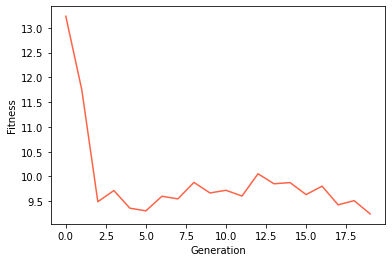

In [ ]:
bestRankDF = pd.DataFrame(bestRank, columns=['Score', 'Schedule'])
bestRank
bestRankDF['Generation'] = bestRankDF.index.values
fig = px.line(bestRankDF, x='Generation', y='Score', hover_data=['Schedule'])
fig.update_traces(line_color='Tomato')
fig.show()


In [ ]:
bestRank = []
precision = 0.9999
N = 24  # number of patients
beta = 9  # average service time for a patient
T = 4*60  # total time
d = 5  # interval size
I = int(T/d)  # number of intervals
no_show = 0
eind = 0
alpha_I = 0.2
alpha_T = 0.4  # patient doctor centric slider
alpha_W = 0.4
popSize = 10
generations = 5
nSwaps = 6

# Initial population
dataObject = Data(N=N, beta=beta, d=d, I=I, no_show=no_show, eind=eind, alpha_I=alpha_I, alpha_T=alpha_T, alpha_W=alpha_W, popSize=popSize, nSwaps=nSwaps)
populationZero = Population(dataObject)
populationZero.calc_fitness_scores()
best_score = min(populationZero.fitnessScores)
score_list = [best_score]
individuals = populationZero.individuals.copy()
fitnessScores = populationZero.fitnessScores.copy()

# Genetic algorithm loop

for i in range(generations):
    print(f'Generation {i}')
    populationObject = Population(dataObject, individuals=individuals)
    populationObject.fitnessScores = fitnessScores
    populationObject.apply_crossover()
    best_score = min(populationObject.fitnessScores)
    score_list.append(best_score)
    individuals = populationObject.individuals.copy()
    fitnessScores = populationObject.fitnessScores.copy()


Schedule: [0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 2
 2 2 0 2 0 2 0 0 1 0 0],
N: 24,
Objective value: 40.225268799586146,
Prob calculation time: 1.496309 sec,
Waiting time (timer): 18.254690896097603 (0.351420 sec),
Idle time (timer): 70.87232073524518 (0.000010 sec),
Tardiness (timer): 46.872320735245175 (0.000112 sec)

Schedule: [1 0 0 0 0 1 0 1 0 2 1 1 0 0 2 0 1 1 0 0 1 0 2 0 2 0 1 0 0 0 0 0 0 0 0 0 1
 1 1 0 0 0 2 1 1 0 0 0],
N: 24,
Objective value: 15.495740042561197,
Prob calculation time: 1.445029 sec,
Waiting time (timer): 14.235076459606965 (0.365649 sec),
Idle time (timer): 32.33618243119736 (0.000002 sec),
Tardiness (timer): 8.336182431197349 (0.000097 sec)

Schedule: [0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 2 0 0 2 2 1 0 0 2 0 1 0 1 1 0 2 0 2 0 0 0 1
 0 1 0 0 0 0 0 0 0 1 0],
N: 24,
Objective value: 21.812321578935652,
Prob calculation time: 1.534795 sec,
Waiting time (timer): 24.351060061970404 (0.412167 sec),
Idle time (timer): 36.11982925691248 (0.000

[12.645221356662818, 10.962733561104429, 10.405839081230672, 9.67722680114548, 9.057014800998326, 8.859642768495625]


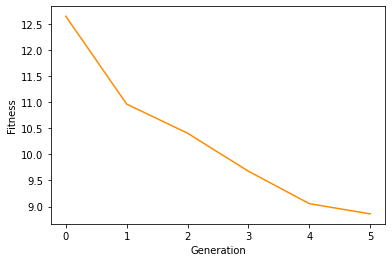

In [ ]:
bestRankDF = pd.DataFrame(bestRank, columns=['Score', 'Schedule'])
bestRank
bestRankDF['Generation'] = bestRankDF.index.values
fig = px.line(bestRankDF, x='Generation', y='Score', hover_data=['Schedule'])
fig.update_traces(line_color='DarkOrange')
fig.show()


In [ ]:
bestRank = []
precision = 0.9999
N = 24  # number of patients
beta = 9  # average service time for a patient
T = 4*60  # total time
d = 5  # interval size
I = int(T/d)  # number of intervals
no_show = 0
eind = 0
alpha_I = 0.2
alpha_T = 0.4  # patient doctor centric slider
alpha_W = 0.4
popSize = 15
generations = 5
nSwaps = 6

# Initial population
dataObject = Data(N=N, beta=beta, d=d, I=I, no_show=no_show, eind=eind, alpha_I=alpha_I, alpha_T=alpha_T, alpha_W=alpha_W, popSize=popSize, nSwaps=nSwaps)
populationZero = Population(dataObject)
populationZero.calc_fitness_scores()
best_score = min(populationZero.fitnessScores)
score_list = [best_score]
individuals = populationZero.individuals.copy()
fitnessScores = populationZero.fitnessScores.copy()

# Genetic algorithm loop

for i in range(generations):
    print(f'Generation {i}')
    populationObject = Population(dataObject, individuals=individuals)
    populationObject.fitnessScores = fitnessScores
    populationObject.apply_crossover()
    best_score = min(populationObject.fitnessScores)
    score_list.append(best_score)
    individuals = populationObject.individuals.copy()
    fitnessScores = populationObject.fitnessScores.copy()


Schedule: [1 0 0 0 0 0 3 1 0 1 0 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 2 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 3 1 1 0 0 0],
N: 24,
Objective value: 23.14325106932956,
Prob calculation time: 1.478254 sec,
Waiting time (timer): 16.972751666069815 (0.287801 sec),
Idle time (timer): 43.25691733816939 (0.000002 sec),
Tardiness (timer): 19.256917338169384 (0.000105 sec)

Schedule: [0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 2 1 0 0 0 1 1 1 0 0 2 1 0 1 1 1 0 1 0 0 0 1
 2 2 1 0 0 1 0 0 0 1 0],
N: 24,
Objective value: 27.407777307186187,
Prob calculation time: 1.432074 sec,
Waiting time (timer): 17.379488743982872 (0.278020 sec),
Idle time (timer): 50.0933030159884 (0.000002 sec),
Tardiness (timer): 26.093303015988393 (0.000102 sec)

Schedule: [2 2 0 0 1 0 0 0 1 2 0 1 1 1 1 2 1 0 0 0 0 0 1 0 0 0 0 1 1 2 0 0 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 1 1],
N: 24,
Objective value: 16.651105413313545,
Prob calculation time: 1.463714 sec,
Waiting time (timer): 17.404786127086123 (0.338576 sec),
Idle time (timer): 32.14865160413183 (0.0000

[10.810400241103189, 9.553632998893647, 8.913796450810315, 8.770518482819648, 8.418365316827495, 8.719111512114981]


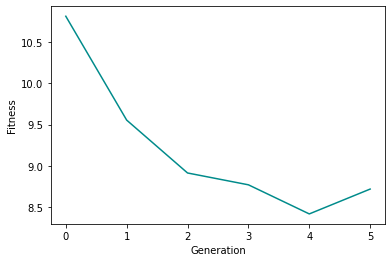

In [ ]:
bestRankDF = pd.DataFrame(bestRank, columns=['Score', 'Schedule'])
bestRank
bestRankDF['Generation'] = bestRankDF.index.values
fig = px.line(bestRankDF, x='Generation', y='Score', hover_data=['Schedule'])
fig.update_traces(line_color='DarkCyan')
fig.show()
